<a href="https://colab.research.google.com/github/madhumitha-r26/DL_Learnings/blob/main/cnn_dog_cat_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import random as rd
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from tensorflow.keras.models import Model


In [2]:

# -------------------------------
# CONFIG
# -------------------------------
TRAIN_DIR = '/content/drive/MyDrive/Colab Notebooks/DL/train'
TEST_DIR  = '/content/drive/MyDrive/Colab Notebooks/DL/test'

IMG_SIZE = 50
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 10



In [3]:

# -------------------------------
# LABEL FUNCTION
# -------------------------------
def create_label(image_name):
    if image_name.startswith('cat'):
        return [1, 0]
    else:
        return [0, 1]



In [4]:

# -------------------------------
# TRAIN DATA
# -------------------------------
def create_train_data():
    X, y = [], []

    for img in tqdm(os.listdir(TRAIN_DIR)):
        path = os.path.join(TRAIN_DIR, img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        img_data = img_data // 255   # ✅ normalize

        X.append(img_data)
        y.append(create_label(img))

    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    y = np.array(y)

    return X, y



In [5]:

# -------------------------------
# TEST DATA
# -------------------------------
def create_test_data():
    X, img_ids = [], []

    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_id = img.split('.')[0]

        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        img_data = img_data // 255   # ✅ normalize

        X.append(img_data)
        img_ids.append(img_id)

    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    return X, img_ids



In [6]:

# -------------------------------
# LOAD DATA
# -------------------------------
X_all, y_all = create_train_data()
X_test_vis, test_img_ids = create_test_data()

# Train / Validation split
split = int(0.9 * len(X_all))
X_train, X_val = X_all[:split], X_all[split:]
y_train, y_val = y_all[:split], y_all[split:]



100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


In [7]:

# -------------------------------
# DATASETS
# -------------------------------
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



In [8]:

# -------------------------------
# MODEL
# -------------------------------
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

x = Conv2D(32, (3,3), activation='relu')(inputs)
x = MaxPooling2D()(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = Flatten()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),loss='categorical_crossentropy',metrics=['accuracy'])



In [9]:

# -------------------------------
# TRAIN
# -------------------------------
model.fit( train_ds, validation_data=val_ds, epochs=EPOCHS )

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6667 - loss: 0.6837 - val_accuracy: 0.0000e+00 - val_loss: 0.8205
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5556 - loss: 0.6311 - val_accuracy: 0.0000e+00 - val_loss: 1.0203
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.5556 - loss: 0.6161 - val_accuracy: 0.0000e+00 - val_loss: 1.2535
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6111 - loss: 0.5584 - val_accuracy: 0.0000e+00 - val_loss: 1.6024
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.6111 - loss: 0.5351 - val_accuracy: 0.0000e+00 - val_loss: 2.1363
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6111 - loss: 0.5145 - val_accuracy: 0.0000e+00 - val_loss: 2.8670
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6111 - loss: 0.5194 - val_accuracy: 0.0000e+00 - val_loss: 3.7352
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6111 - loss: 0.4959 - val_acc

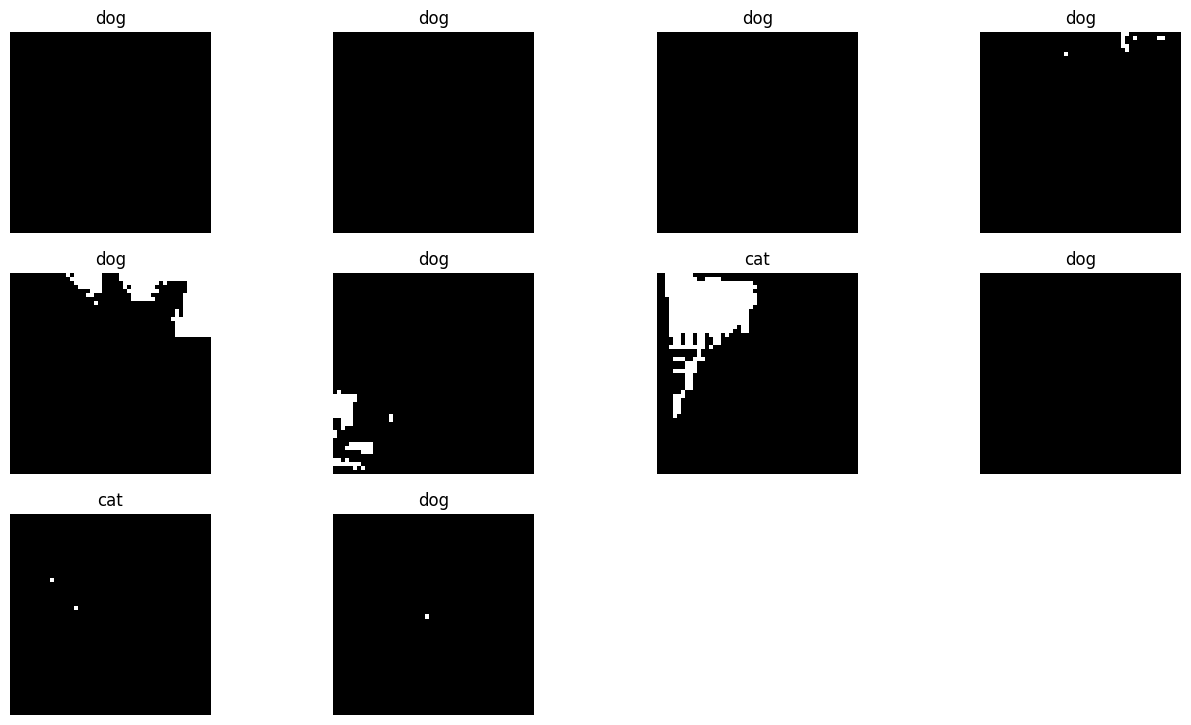

In [11]:

# -------------------------------
# PREDICTION & VISUALIZATION
# -------------------------------
fig = plt.figure(figsize=(16, 12))

# Limit the loop to the number of available test images or a maximum of 16
for i in range(min(16, len(X_test_vis))):
    img = X_test_vis[i].reshape(1, IMG_SIZE, IMG_SIZE, 1)
    prediction = model.predict(img, verbose=0)[0]

    label = 'dog' if np.argmax(prediction) == 1 else 'cat'

    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(X_test_vis[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    ax.set_title(label)
    ax.axis('off')

plt.show()
